In [1]:
from sklearn.decomposition import PCA
import numpy as np
import h5py

def inspect_h5(file):
    """
    Inspect the structure of an HDF5 file.

    Args:
        file (str): Path to the HDF5 file.
    """
    with h5py.File(file, 'r') as f:
        print(f"Inspecting {file}:")
        print(f['008bd5ad93b754d5'])
        for key in f.keys():
            print(f"{key}: {list(f[key].keys()) if isinstance(f[key], h5py.Group) else 'Dataset'}")
# Inspect descriptors and keypoints files
inspect_h5("../data/feature_descriptors/descriptors.h5")
#inspect_h5("../data/feature_descriptors/keypoints.h5")

Inspecting ../data/feature_descriptors/descriptors.h5:
<HDF5 dataset "008bd5ad93b754d5": shape (288, 128), type "<f2">
0004d0b59e19461f: Dataset
000871c1fc726f0b: Dataset
0084ae4bc24c0795: Dataset
008bd5ad93b754d5: Dataset
00b76fddeaaa7d8c: Dataset
00ec53c4682d36f5: Dataset
01161aaa0b6d1345: Dataset
01386bd6d8e091c2: Dataset
01882513d5fa7c32: Dataset
0189caa552598b84: Dataset
018b59ce1fd616d8: Dataset
01931a6925d3de09: Dataset
019d385eb67632a7: Dataset
01f78be6f7cad026: Dataset
020bf2c45e7bb322: Dataset
022400dffec5b447: Dataset
0233f3bb964cf325: Dataset
0266e33d3f546cb5: Dataset
026a39ae63343c68: Dataset
02a32ad2669e6fe2: Dataset
02b5b45ce743bc3f: Dataset
0314c9b108b8c39f: Dataset
032dd17b77fab7d5: Dataset
0336dcbab05b9d5a: Dataset
037a595e6f4f0576: Dataset
03bfc1d4783966c6: Dataset
03c6b06952c75089: Dataset
03e0704b5690a2de: Dataset
03e7d2ebec1e820a: Dataset
03f5446139179452: Dataset
03fa2f7502f5f6b9: Dataset
04025959b191f8f9: Dataset
0415740eaa4d9dec: Dataset
043ab21fc5a1607b: Datas

In [2]:
def load_keypoints_and_descriptors(keypoins_file, descriptors_file):
    data = {}
    with h5py.File(keypoins_file, 'r') as kf, h5py.File(descriptors_file, 'r') as df:
        for key in kf.keys():
            if key in df:
                keypoints = np.array(kf[key])
                descriptors = np.array(df[key])
                data[key] = (keypoints, descriptors)
            else:
                print(f"Key {key} not found in descriptors file.")
    return data

keypoints_file = "../data/feature_descriptors/keypoints.h5"
descriptors_file = "../data/feature_descriptors/descriptors.h5"

dataset = load_keypoints_and_descriptors(keypoints_file, descriptors_file)
print(f"Loaded dataset with {len(dataset)} images.")
    

Loaded dataset with 1887 images.


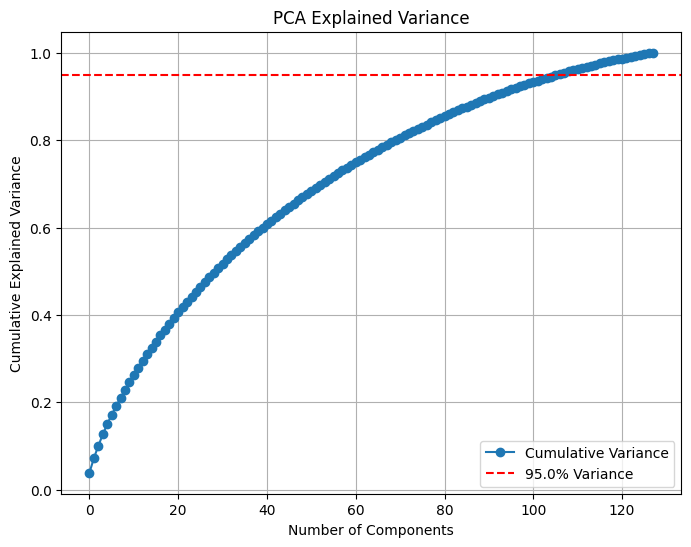

Optimal PCA components: 107


In [68]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

def test_pca_variance(descriptors, variance_threshold = 0.95):
    pca = PCA().fit(descriptors)
    explained_variance_ratio = np.cumsum(pca.explained_variance_ratio_)
    # Plot the explained variance
    plt.figure(figsize=(8, 6))
    plt.plot(explained_variance_ratio, marker='o', label="Cumulative Variance")
    plt.axhline(y=variance_threshold, color='r', linestyle='--', label=f"{variance_threshold * 100}% Variance")
    plt.xlabel("Number of Components")
    plt.ylabel("Cumulative Explained Variance")
    plt.title("PCA Explained Variance")
    plt.legend()
    plt.grid()
    plt.show()

    # Find the optimal number of components
    optimal_components = np.argmax(explained_variance_ratio >= variance_threshold) + 1
    return pca, optimal_components

# Example usage
pca_model, optimal_pca_components = test_pca_variance(all_descriptors)
print(f"Optimal PCA components: {optimal_pca_components}")

In [69]:
def train_pca(descriptor_file, n_components):

    descriptors = []
    with h5py.File(descriptor_file, 'r') as f:
        for image_id in f.keys():
            descriptors.append(np.array(f[image_id]))
    all_descriptors = np.vstack(descriptors)

    # Train PCA
    pca = PCA(n_components=n_components)
    pca.fit(all_descriptors)
    print(f"PCA trained with {n_components} components.")
    return pca, all_descriptors

# Example usage
descriptor_file = "../data/feature_descriptors/descriptors.h5"
n_components = 107  # Set based on explained variance (e.g., 95%)
pca_model, all_descriptors = train_pca(descriptor_file, n_components)
#print('what?')

PCA trained with 107 components.


In [3]:
def load_keypoints(file_path):

    keypoints = []
    with h5py.File(file_path, 'r') as f:
        for image_id in f.keys():
            keypoints.append(np.array(f[image_id]))
    keypoints = np.vstack(keypoints)
    return keypoints


# Example usage
keypoints_file = "../data/feature_descriptors/keypoints.h5"
keypoints = load_keypoints(keypoints_file)
#print(f"Loaded keypoints for {len(keypoints)} images.")
print(keypoints.shape)

(710282, 2)


In [4]:
def load_descriptors(file_path):

    descriptors = []
    with h5py.File(file_path, 'r') as f:
        for image_id in f.keys():
            descriptors.append(np.array(f[image_id]))
    descriptors = np.vstack(descriptors)

    return descriptors

# Example usage
descriptors_file = "../data/feature_descriptors/descriptors.h5"
descriptors = load_descriptors(descriptors_file)
print(descriptors.shape)

(710282, 128)


In [5]:
print(len(descriptors))

710282


In [116]:
from scipy.spatial.distance import cdist
comparison_path_1 = 'data/segmented_dataset/0/1cfead9959b76ce4.jpg'
comparison_path_2 = 'data/segmented_dataset/0/abec16f483abb4f1.jpg'
def load_scores(score_file):

    scores = {}
    with h5py.File(score_file, 'r') as f:
        for image_id in f.keys():
            scores[image_id] = np.array(f[image_id])  # Load scores
    return scores

# Example usage
descriptor_file = "../data/feature_descriptors/descriptors.h5"
descriptors = load_scores(descriptor_file)
print(f"Loaded scores for {len(scores)} images.")

a = descriptors['abec16f483abb4f1']
b = descriptors['1cfead9959b76ce4']

def normalize_descriptors(descriptors):
    return descriptors / np.linalg.norm(descriptors, axis=1, keepdims=True)

normalized_descriptors1 = normalize_descriptors(a)
normalized_descriptors2 = normalize_descriptors(b)

# Compute similarity using Euclidean distance
euc_distances = cdist(a, b, metric='euclidean')

# Compute similarity using Cosine similarity (1 - cosine distance)
cos_similarities = 1 - cdist(normalized_descriptors1, normalized_descriptors2, metric='cosine')
print(f"Euclidean distance: {euc_distances}")
print(f"Cosine similarity: {cos_similarities}") 

# Using Euclidean distance
best_matches_euclidean = np.argmin(euc_distances, axis=1)  # Index of closest descriptor in Image 2

# Using Cosine similarity
best_matches_cosine = np.argmax(cos_similarities, axis=1)  # Index of most similar descriptor in Image 2

# Example output for first 5 descriptors
print("Best matches for first 5 descriptors using Euclidean distance:")
for i in range(5):
    print(f"Descriptor {i} in Image 1 matches with Descriptor {best_matches_euclidean[i]} in Image 2")

print("\nBest matches for first 5 descriptors using Cosine similarity:")
for i in range(5):
    print(f"Descriptor {i} in Image 1 matches with Descriptor {best_matches_cosine[i]} in Image 2")

print(np.min(euc_distances))
print(np.max(cos_similarities))


Loaded scores for 1887 images.
Euclidean distance: [[1.01967597 1.13452332 0.89494193 ... 1.34523255 1.1312693  1.05572189]
 [1.11076331 1.11730023 0.98516936 ... 1.32146972 0.99075821 1.05005438]
 [1.05077517 1.02062168 1.18330592 ... 1.31649314 1.07174441 1.00303156]
 ...
 [1.19886718 1.03913566 1.19952949 ... 1.27647758 0.79403203 1.00661079]
 [1.19735489 1.1267973  1.21200818 ... 1.18183735 0.98024959 0.9198034 ]
 [1.28464026 1.13601518 1.22700578 ... 1.35453445 0.88870393 1.00623307]]
Cosine similarity: [[0.48013816 0.35641691 0.59952564 ... 0.09516109 0.36005408 0.44271675]
 [0.383106   0.3758033  0.51469952 ... 0.12683787 0.509148   0.44867911]
 [0.44792946 0.47914271 0.29985098 ... 0.13338713 0.4256123  0.4969426 ]
 ...
 [0.28135392 0.46007727 0.28052416 ... 0.18527271 0.68471982 0.49334836]
 [0.28319655 0.36516612 0.26550839 ... 0.30163465 0.51951997 0.57698313]
 [0.17487041 0.35472986 0.24721014 ... 0.08261386 0.60506919 0.49374462]]
Best matches for first 5 descriptors using

In [85]:
def combine_keypoints_and_descriptors(keypoints, descriptors):

    assert len(keypoints) == len(descriptors), "Number of keypoints and descriptors must match."
    
    # Combine into a dictionary for further processing
    combined_data = {
        "keypoints": keypoints,
        "descriptors": descriptors,
    }
    return combined_data

# Example usage
sparse_keypoints = descriptors  # Simulated keypoints (N, 2)
sparse_descriptors =keypoints
combined_data = combine_keypoints_and_descriptors(sparse_keypoints, sparse_descriptors)

print(f"Keypoints shape: {combined_data['keypoints'].shape}")
print(f"Descriptors shape: {combined_data['descriptors'].shape}")

Keypoints shape: (710282, 128)
Descriptors shape: (710282, 2)


In [ ]:
def aggregate_descriptors(dataset):
    """
    Aggregate descriptors from all images into a global array.

    Args:
        dataset (dict): Dictionary of combined keypoints and descriptors for each image.

    Returns:
        np.ndarray: Global array of all descriptors (M, D), where M is the total number of descriptors.
    """
    global_descriptors = []
    for image_id, data in dataset.items():
        global_descriptors.append(data["descriptors"])
    
    return np.vstack(global_descriptors)

In [86]:
def apply_pca_to_descriptors(descriptor_file, output_file, pca_model):

    with h5py.File(descriptor_file, 'r') as desc_f, h5py.File(output_file, 'w') as out_f:
        for image_id in desc_f.keys():
            descriptors = np.array(desc_f[image_id])
            pca_descriptors = pca_model.transform(descriptors)
            out_f.create_dataset(image_id, data=pca_descriptors, dtype = np.float32)
            print(f"Processed {image_id}")

output_file = "../data/feature_descriptors/descriptors_pca.h5"
apply_pca_to_descriptors(descriptor_file, output_file, pca_model)

Processed 0004d0b59e19461f
Processed 000871c1fc726f0b
Processed 0084ae4bc24c0795
Processed 008bd5ad93b754d5
Processed 00b76fddeaaa7d8c
Processed 00ec53c4682d36f5
Processed 01161aaa0b6d1345
Processed 01386bd6d8e091c2
Processed 01882513d5fa7c32
Processed 0189caa552598b84
Processed 018b59ce1fd616d8
Processed 01931a6925d3de09
Processed 019d385eb67632a7
Processed 01f78be6f7cad026
Processed 020bf2c45e7bb322
Processed 022400dffec5b447
Processed 0233f3bb964cf325
Processed 0266e33d3f546cb5
Processed 026a39ae63343c68
Processed 02a32ad2669e6fe2
Processed 02b5b45ce743bc3f
Processed 0314c9b108b8c39f
Processed 032dd17b77fab7d5
Processed 0336dcbab05b9d5a
Processed 037a595e6f4f0576
Processed 03bfc1d4783966c6
Processed 03c6b06952c75089
Processed 03e0704b5690a2de
Processed 03e7d2ebec1e820a
Processed 03f5446139179452
Processed 03fa2f7502f5f6b9
Processed 04025959b191f8f9
Processed 0415740eaa4d9dec
Processed 043ab21fc5a1607b
Processed 043c3d7e489c69b4
Processed 044a23cadb567653
Processed 05128e44e27c36bd
P

In [87]:
def check_descriptor_stats(descriptor_file):

    descriptors = []
    with h5py.File(descriptor_file, 'r') as f:
        for image_id in f.keys():
            descriptors.append(np.array(f[image_id]))
    all_descriptors = np.vstack(descriptors)

    print(f"Descriptor Stats (Raw):")
    print(f"  Min: {np.min(all_descriptors):.4f}")
    print(f"  Max: {np.max(all_descriptors):.4f}")
    print(f"  Mean: {np.mean(all_descriptors):.4f}")
    print(f"  Std: {np.std(all_descriptors):.4f}")

# Example usage
check_descriptor_stats("../data/feature_descriptors/descriptors_pca.h5")

Descriptor Stats (Raw):
  Min: -0.5929
  Max: 0.7489
  Mean: 0.0000
  Std: 0.0774


GMM with 63 components trained.
Log-Likelihood per sample: 132.4981
GMM with 64 components trained.
Log-Likelihood per sample: 132.6238


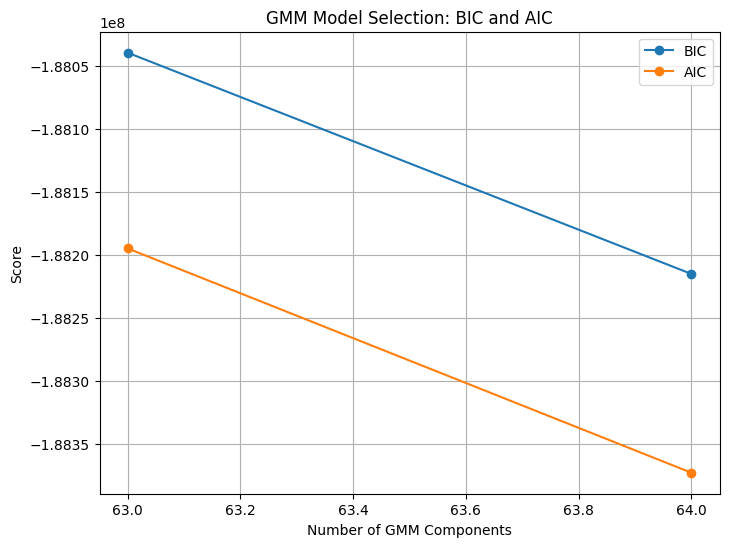

In [90]:
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
def evaluate_gmm_components(reduced_descriptor_file, max_components):
    """
    Evaluate GMM models with different numbers of components using BIC and AIC.

    Args:
        reduced_descriptor_file (str): Path to the PCA-reduced descriptors HDF5 file.
        max_components (int): Maximum number of GMM components to test.

    Returns:
        dict: Dictionary containing BIC and AIC scores for each component count.
    """
    #descriptors = []
    #with h5py.File(reduced_descriptor_file, 'r') as f:
    #    for image_id in f.keys():
    #        descriptors.append(np.array(f[image_id]))
    #all_descriptors = np.vstack(descriptors)
    reduced_descriptors = reduced_descriptor_file
    bic_scores = []
    aic_scores = []
    n_components_range = range(63, max_components + 1)

    for n_components in n_components_range:
        gmm = GaussianMixture(n_components=n_components, covariance_type='diag', random_state=42, reg_covar=1e-3)
        gmm.fit(reduced_descriptors)

        bic_scores.append(gmm.bic(reduced_descriptors))
        aic_scores.append(gmm.aic(reduced_descriptors))
        print(f"GMM with {n_components} components trained.")
        log_likelihood = gmm.score(reduced_descriptors)
        print(f"Log-Likelihood per sample: {log_likelihood:.4f}")
    # Plot the scores
    import matplotlib.pyplot as plt
    plt.figure(figsize=(8, 6))
    plt.plot(n_components_range, bic_scores, label="BIC", marker='o')
    plt.plot(n_components_range, aic_scores, label="AIC", marker='o')
    plt.xlabel("Number of GMM Components")
    plt.ylabel("Score")
    plt.title("GMM Model Selection: BIC and AIC")
    plt.legend()
    plt.grid()
    plt.show()

    return {"bic": bic_scores, "aic": aic_scores}

# Example usage
max_components = 64
reduced_descriptors_file = "../data/feature_descriptors/descriptors_pca.h5"
reduced_descriptors = []
with h5py.File(reduced_descriptors_file, 'r') as f:
    for image_id in f.keys():
        reduced_descriptors.append(np.array(f[image_id]))
all_descriptors = np.vstack(reduced_descriptors)
#n_components_range = range(1, 2)  # Test GMM with 1 to 10 components

gmm_scores = evaluate_gmm_components(all_descriptors, max_components)